# C5 injeciton data analysis

## Lib import

In [804]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from sklearn import metrics
from sklearn.metrics import mean_squared_error, explained_variance_score, r2_score, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_regression

from scipy.special import expi
from scipy.stats import pearsonr
from scipy.optimize import curve_fit

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

import warnings
warnings.filterwarnings('ignore')
cmap = plt.cm.plasma

## Declare functions

In [925]:
def random_forest(X_train, X_test, y_train, y_test):
    rf = RandomForestRegressor()   # instantiate the random forest  
    rf = rf.fit(X_train, y_train) # fit the random forest

    prediction = rf.predict(X_test).reshape(-1,1)  #1d array convert to 2d
    MSE = mean_squared_error(y_test, prediction)
    Var_Exp = explained_variance_score(y_test, prediction)
    R2 = r2_score(y_test, prediction)
    corr = math.sqrt(R2)
    error = prediction-y_test.values
    mean = np.mean(error)
    std = np.std(error)
    
    return rf, prediction, MSE, Var_Exp, R2, corr, error, mean, std


def k_nearest(X_train_s, X_test_s, y_train_s, y_test, weights, n_neighbors, p): 
    neigh = KNeighborsRegressor(weights = weights, n_neighbors=n_neighbors, p = p)
    neigh_fit = neigh.fit(X_train_s,y_train_s)
    
    prediction_s = neigh_fit.predict(X_test_s)   #1d array
    prediction = scaler_y.inverse_transform(prediction_s.reshape(-1,1))  #convert to 2d array
    MSE = mean_squared_error(y_test, prediction)
    Var_Exp = explained_variance_score(y_test, prediction)
    R2 = r2_score(y_test, prediction)
    corr = math.sqrt(abs(R2))
    error = prediction-y_test.values   #2d arrays, both 1d and 2d works in numpy
    mean = np.mean(error)
    std = np.std(error)
    
    return neigh_fit, prediction, MSE, Var_Exp, R2, corr, error, mean, std


def boosting(X_train, X_test, y_train, y_test, max_depth, learning_rate, num_tree):
    params = {
        'loss': 'ls',                         
        'max_depth': max_depth,                 
        'learning_rate': learning_rate,
        'criterion': 'mse'                 
    }
    boosting_model = GradientBoostingRegressor(n_estimators=int(num_tree),**params)
    boosting_model.fit(X_train,y_train)
    prediction = boosting_model.predict(X_test).reshape(-1,1)
    MSE = mean_squared_error(y_test, prediction)
    Var_Exp = explained_variance_score(y_test, prediction)
    R2 = r2_score(y_test, prediction)
    corr = math.sqrt(R2)
    error = prediction-y_test.values
    mean = np.mean(error)
    std = np.std(error)
    
    return boosting_model, prediction, MSE, Var_Exp, R2, corr, error, mean, std

def lasso(X_train, X_test, y_train, y_test, lam):
    lam = lam; lasso_reg = Lasso(alpha=lam); lasso_reg.fit(X_train,y_train)
    
    prediction_L = lasso_reg.predict(X_test).reshape(-1,1)
    MSE_L = mean_squared_error(y_test, prediction_L)
    Var_Exp_L = explained_variance_score(y_test, prediction_L)
    R2_L = r2_score(y_test, prediction_L)
    corr_L = math.sqrt(R2_L)
    error_L = prediction_L-y_test
    mean_L = np.mean(error_L)
    std_L = np.std(error)
    
    return lasso_reg, prediction_L, MSE_L, Var_Exp_L, R2_L, corr_L, error_L, mean_L, std_L


def BHP_backtransform(prediction, df, y_test):  # Prediction backtransform to BHP (for time after 800 days)
    BHP_backtransform = []
    for i in range(len(prediction)):  # 2d array of prediction for imputed
        if i == 0:
            BHP_backtransform.append(df.BHP[14032])
        else:
            if y_test.dP[i] == 0:
                BHP_backtransform.append(df.BHP[14032+i]+prediction[i,0])
            else: 
                BHP_backtransform.append(BHP_backtransform[i-1] + (prediction[i,0]-prediction[i-1,0]))
    return np.array([BHP_backtransform]).reshape(-1,1)


def plot_results(Y, df, prediction, MSE, Var_Exp, R2, corr, error, mean, std): # Y inputed as 2d array (y_test..)
    print('Error standard deviation is ' + str("{:.2f}".format(std)) + ' bar')
    print('Mean squared error is ' + str("{:.2f}".format(MSE)))
    print('Coefficiant of determination is ' + str("{:.3f}".format(R2)))
    print('Correlation coefficient is ' + str("{:.3f}".format(corr)))
    print('Variance explained score is ' + str("{:.3f}".format(Var_Exp)))
    
    if prediction[1,0] > 100:
        BHP_predicted = prediction
    else:
        BHP_predicted = BHP_backtransform(prediction, df, Y) # y_test is needed to find dP = 0 -> for curve adjust
    BHP_actual = df.loc[df.time>800, ['BHP']].values       
    T = df.loc[df.time>800, ['time']].values 
    
    plt.subplot(1,2,1)
    plt.plot(T, BHP_actual, linewidth=3, label='Actual BHP')
    plt.plot(T, BHP_predicted, linewidth=3, c='r', label='Predicted BHP')
    plt.title('Pressure pattern prediction', fontsize=15); 
    plt.ylabel('BHP, bar', fontsize=15); plt.xlabel('time, days', fontsize=15)
    plt.xticks(fontsize=15); plt.yticks(fontsize=15);
    plt.legend(); plt.grid()

    plt.subplot(1,2,2)
    plt.hist(error, color='orange', edgecolor='black', bins=20)
    plt.ylabel('Frequency', fontsize=15); plt.xlabel('Error, bar', fontsize=15)
    plt.xticks(fontsize=15); plt.yticks(fontsize=15);
    plt.title('Error distribution', fontsize=15)

    plt.subplots_adjust(left=0.0, bottom=0.0, right=3.0, top=1.5, wspace=0.2, hspace=0.2)
    plt.show()
    

def plot_predictions(Y, df, prediction_R, prediction_B, prediction_N):
    
    predictions = [prediction_R, prediction_B, prediction_N]
    BHP_predicted = []
    for prediction in predictions:
        if prediction[1,0] > 100:
            BHP_predicted.append(prediction)
        else:
            BHP_predicted.append(BHP_backtransform(prediction, df, Y))
    BHP_actual = df.loc[df.time>800, ['BHP']].values       
    T = df.loc[df.time>800, ['time']].values
    
    plt.plot(T, BHP_actual, linewidth=3, label='Actual BHP')
    plt.plot(T, BHP_predicted[0], linewidth=3, label='Random forest results')
    plt.grid()
    plt.show()

## Data import

In [3]:
df = pd.read_pickle('C5.pkl')
df_noise = pd.read_pickle('C5+noise.pkl')

In [4]:
df = df.reset_index()
df_noise = df_noise.reset_index()

In [5]:
df_noise.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
time,18688.0,520.582070,326.101355,0.000000,219.427327,547.362389,798.397486,1094.970346
TIMESTEP,18688.0,0.058592,0.046355,0.000000,0.001869,0.100000,0.100000,0.100000
BHP,18688.0,328.823014,10.230526,300.000000,321.421775,330.275850,337.810375,347.596000
q,18688.0,226.458114,115.749766,0.000000,206.859000,244.014500,305.372250,421.461000
FPR,18688.0,308.395752,5.273260,300.000000,303.114550,309.390900,312.650600,317.678000
periods1,8918.0,10.998879,24.050347,-41.000000,1.000000,17.000000,27.000000,45.000000
periods2,9815.0,21.163118,19.462562,-28.000000,12.000000,24.000000,36.000000,46.000000
A,18688.0,300.000000,0.000000,300.000000,300.000000,300.000000,300.000000,300.000000
B,18688.0,0.098844,0.021066,0.050343,0.086725,0.100750,0.110842,0.140662
THP,18688.0,39.831343,16.199219,0.000000,27.719007,42.240908,53.057910,83.232497


## Curve fit

In [6]:
#Data separation for curve fit
df1 = df.loc[(df['time']>0.01) & (df['time']<5),:]; df1.reset_index(drop=True, inplace=True)
df1['BHP'] = df1['BHP'] - 300
df1['BHP'] = df1['BHP']*14.5038
df1['time'] = df1['time']*24

df2 = df.loc[(df['time']>115) & (df['time']<126),:]; df2.reset_index(drop=True, inplace=True)
df2 = df2.iloc[np.argmin(df2['BHP']):,:]; df2.reset_index(drop=True, inplace=True)
df2['BHP'] = df2['BHP'] - df2['BHP'][0]
df2['time'] = df2['time'] - df2['time'][0]
df2 = df2.loc[df2['time']>0.01,:]; df2.reset_index(drop=True, inplace=True)
df2['BHP'] = df2['BHP']*14.5038
df2['time'] = df2['time']*24

df3 = df.loc[(df['time']>195) & (df['time']<205),:]; df3.reset_index(drop=True, inplace=True)
df3 = df3.iloc[48:,:]; df3.reset_index(drop=True, inplace=True)   # drop at 48th index
df3['BHP'] = df3['BHP'] - df3['BHP'][0]
df3['time'] = df3['time'] - df3['time'][0]
df3 = df3.loc[df3['time']>0.01,:]; df3.reset_index(drop=True, inplace=True)
df3['BHP'] = df3['BHP']*14.5038
df3['time'] = df3['time']*24

df4 = df.loc[(df['time']>253) & (df['time']<259),:]; df4.reset_index(drop=True, inplace=True)
df4 = df4.iloc[8:,:]; df4.reset_index(drop=True, inplace=True)   # drop at 7th index
df4['BHP'] = df4['BHP'] - df4['BHP'][0]
df4['time'] = df4['time'] - df4['time'][0]
df4 = df4.loc[df4['time']>0.005,:]; df4.reset_index(drop=True, inplace=True)
df4['BHP'] = df4['BHP']*14.5038
df4['time'] = df4['time']*24

df5 = df.loc[(df['time']>435) & (df['time']<450),:]; df5.reset_index(drop=True, inplace=True)
df5 = df5.iloc[55:,:]; df5.reset_index(drop=True, inplace=True)
df5['BHP'] = df5['BHP'] - df5['BHP'][0]
df5['time'] = df5['time'] - df5['time'][0]
df5 = df5.loc[df5['time']>0.02,:]; df5.reset_index(drop=True, inplace=True)
df5['BHP'] = df5['BHP']*14.5038
df5['time'] = df5['time']*24

df6 = df.loc[(df['time']>600) & (df['time']<639),:]; df6.reset_index(drop=True, inplace=True)
df6 = df6.iloc[np.argmin(df6['BHP']):,:]; df6.reset_index(drop=True, inplace=True)
df6['BHP'] = df6['BHP'] - df6['BHP'][0]
df6['time'] = df6['time'] - df6['time'][0]
df6 = df6.loc[df6['time']>0.01,:]; df6.reset_index(drop=True, inplace=True)
df6['BHP'] = df6['BHP']*14.5038
df6['time'] = df6['time']*24

df7 = df.loc[(df['time']>750) & (df['time']<757.5),:]; df7.reset_index(drop=True, inplace=True) #
df7 = df7.iloc[21:,:]; df7.reset_index(drop=True, inplace=True)
df7['BHP'] = df7['BHP'] - df7['BHP'][0]
df7['time'] = df7['time'] - df7['time'][0]
df7 = df7.loc[df7['time']>0.01,:]; df7.reset_index(drop=True, inplace=True)
df7['BHP'] = df7['BHP']*14.5038
df7['time'] = df7['time']*24

df8 = df.loc[(df['time']>950) & (df['time']<957),:]; df8.reset_index(drop=True, inplace=True)
df8 = df8.iloc[np.argmin(df8['BHP']):,:]; df8.reset_index(drop=True, inplace=True)
df8['BHP'] = df8['BHP'] - df8['BHP'][0]
df8['time'] = df8['time'] - df8['time'][0]
df8 = df8.loc[df8['time']>0.01,:]; df8.reset_index(drop=True, inplace=True)
df8['BHP'] = df8['BHP']*14.5038
df8['time'] = df8['time']*24

#df9 = df.loc[(df['time']>950) & (df['time']<1037),:]; df9.reset_index(drop=True, inplace=True)
#df9 = df9.iloc[np.argmin(df9['BHP']):,:]; df9.reset_index(drop=True, inplace=True)
#df9['BHP'] = df9['BHP'] - df9['BHP'][0]
#df9['time'] = df9['time'] - df9['time'][0]
#df9 = df9.loc[df9['time']>80,:]; df9.reset_index(drop=True, inplace=True)
#df9['BHP'] = df9['BHP']*14.5038
#df9['time'] = df9['time']*24

In [756]:
# A parameter calculation. In previous realisations - mobility.

mobility = []
rel_mobility = []
b = []
c = []
dTHP = []
dt = []
data = [df1,df2,df3,df4,df5,df6,df7,df8]
for d in data:
    coef = np.polyfit(np.log10((d['time']).astype(float)),(d['BHP']).astype(float),1)
    #mob = 162.6*d.q[1]/0.159/coef[0]
    mob = 162.6/coef[0]
    b.append(coef[1])
    c.append(coef[0])
    mobility.append(mob)
    dTHP.append(d.THP[len(d)-1]-d.THP[0])
    dt.append(d.time[len(d)-1]-d.time[0])
    d['log_approx'] = coef[0]*np.log10(d['time'])+coef[1]
for i in range(len(mobility)):
    rel_mobility.append(mobility[i]/mobility[0])

# time of mobility estimation 
# !3d mobility was measured at the time 195 days; 4th at 260 days; 6th at 760 days
time = [2, 125, 195, 270, 440, 655, 795, 960]

[30.46905890304524, 30.358499536019764, 29.407102804356573, 33.269937374022966, 34.983255644220016, 29.828026274584936, 33.70868426708919, 28.932511462172656]


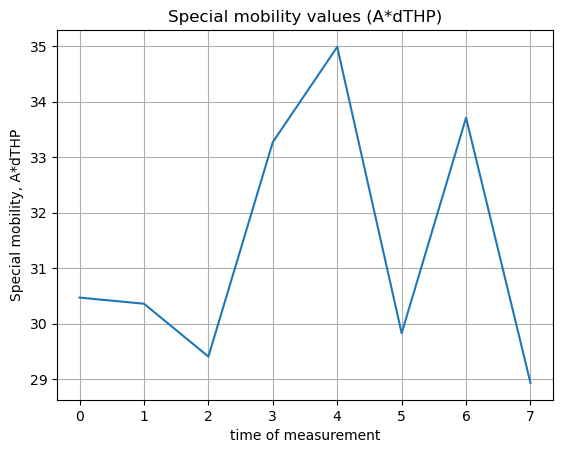

In [757]:
# reservoir mobility * dTHP
spec_mob = []
for i in range(len(mobility)):
    spec_mob.append(mobility[i]*abs(dTHP[i]))
print(spec_mob)
plt.plot(range(8), spec_mob); 
plt.title('Special mobility values (A*dTHP)'); 
plt.xlabel('time of measurement'); plt.ylabel('Special mobility, A*dTHP')
plt.grid()

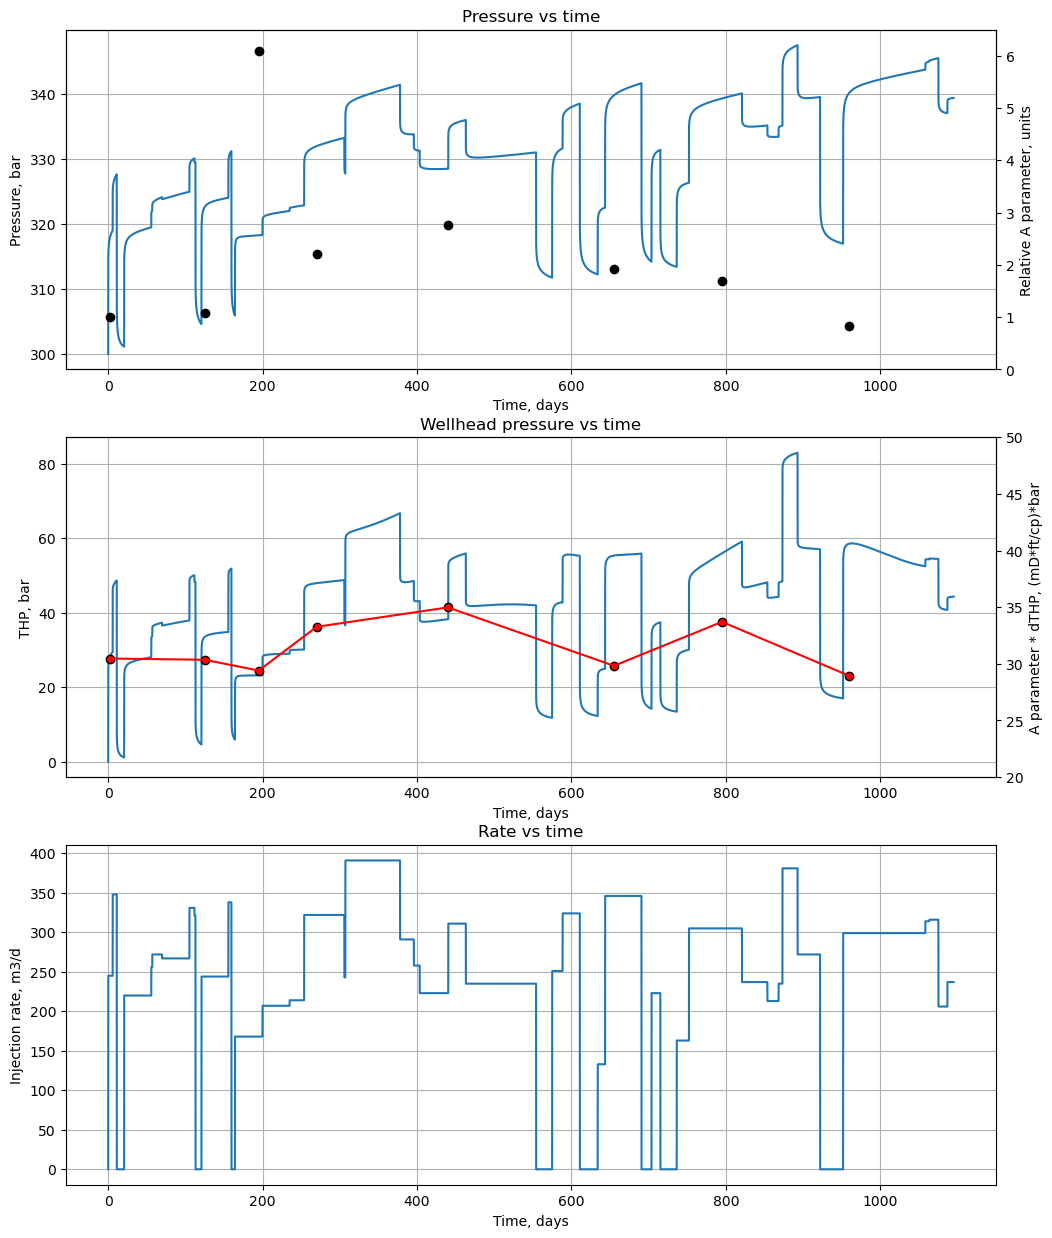

In [710]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(12,15))
ax4 = ax1.twinx()
#ax5 = ax1.twinx()
ax1.plot(df['time'], df['BHP'])
ax1.set_title('Pressure vs time'); ax1.set_xlabel('Time, days'); ax1.set_ylabel('Pressure, bar')
ax4.scatter(time, rel_mobility, c='k'); ax4.set_ylabel('Relative A parameter, units'); ax4.set_ylim(0,6.5)
#ax5.plot(df.time, df.BHT, c='r')

ax2.plot(df['time'], df.THP)
ax2.set_title('Wellhead pressure vs time'); ax2.set_xlabel('Time, days'); ax2.set_ylabel('THP, bar')
ax6 = ax2.twinx()
ax6.scatter(time, spec_mob, c='r', edgecolor='k'), ax6.set_ylabel('A parameter * dTHP, (mD*ft/cp)*bar')
ax6.plot(time,spec_mob, c='r'); 
ax6.set_ylim(20,50)

ax3.plot(df['time'], df.q)
ax3.set_title('Rate vs time'); ax3.set_xlabel('Time, days'); ax3.set_ylabel('Injection rate, m3/d')

ax1.grid(); ax2.grid(); ax3.grid()

## Models

### Data engineering. Train test split. Scaling. Feature creation

**Important notes:**
* flowrate chages after breakpoint (in the next data point row)
* slicing using flowrate gives much better result than using breakpoint slicing (+changing q to a new one in the first data point row)

In [329]:
# Feature engineering

dt = [0]; dP = [0]; dTHP = [0]; pq = [0]; dq = [0]; q = [0];
#for i in range(len(df)):
#    if df.breakpoint[i]:
#        dt.append(0); dP.append(0); dTHP.append(0); pq.append(df.q[i]); 
#        dq.append(df.q[i+1]-df.q[i]) # delta flowrate
#        q.append(df.q[i+1])   # take next flowrate, because at the time 0 - there is still previous flow rate
#    else:
#        dt.append(dt[i-1]+df.TIMESTEP[i])
#        dP.append(dP[i-1]+(df.BHP[i]-df.BHP[i-1]))
#        dTHP.append(dTHP[i-1]+(df.THP[i]-df.THP[i-1]))
#        pq.append(pq[i-1])  # previous flowrate
#        dq.append(dq[i-1])  # delta flowrate
#        q.append(q[i-1])

for i in range(1,len(df)):
    if df.q[i] == df.q[i-1]:
        dt.append(dt[i-1]+df.TIMESTEP[i])
        dP.append(dP[i-1]+(df.BHP[i]-df.BHP[i-1]))
        dTHP.append(dTHP[i-1]+(df.THP[i]-df.THP[i-1]))
        pq.append(pq[i-1])  # previous flowrate
        dq.append(dq[i-1])  # delta flowrate
        #q.append(q[i-1])   # not needed while slicing not by breakpoint, but flowrate 
    else:
        dt.append(0); dP.append(0); dTHP.append(0); pq.append(df.q[i-1]); 
        dq.append(df.q[i]-df.q[i-1]) # delta flowrate
        #q.append(df.q[i+1]) # not needed while slicing not by breakpoint, but flowrate

# shutin time
shutin = [0]
for i in range(1,len(df)):
    if df.q[i] == 0.0:
        shutin.append(0)
    else: 
        shutin.append(shutin[i-1]+df.TIMESTEP[i])

# Adding noise to THP:
std_error = 1.2
THP_noise = df['THP'] + np.random.normal(loc = 0.0,scale=std_error,size=len(df))
dTHP_noise = dTHP + np.random.normal(loc = 0.0,scale=std_error,size=len(df))
        
# Naive case
data1 = df.loc[:,['time', 'q', 'FPR', 'THP', 'B', 'BHP']]
# Data augmentation
#data1_noise = df_noise.loc[df_noise.time<800,['time', 'q', 'FPR', 'THP', 'B', 'BHP']]
#data1 = pd.concat([data1_noise,data1])

# Using created features - dq
data2 = df.loc[:,['FPR', 'B']]
data2['dt'] = dt; data2['dTHP'] = dTHP; data2['shutin'] = shutin; data2['dq'] = dq; 
data2['dP'] = dP

# Using created features - with THP_noise
data3 = df.loc[:,['FPR', 'B']]
data3['dt'] = dt; data3['dTHP_noise'] = dTHP_noise; data3['shutin'] = shutin; data3['dq'] = dq; 
data3['dP'] = dP

# Without THP
data4 = df.loc[:, ['FPR', 'B']]
data4['dt'] = dt; data4['shutin'] = shutin; data4['dq'] = dq; 
data4['dP'] = dP

# Using q and prev_q
data5 = df.loc[:,['q','FPR', 'B']]
data5['dt'] = dt; data5['dTHP'] = dTHP; data5['shutin'] = shutin; data5['prev_q'] = pq;
data5['dP'] = dP

In [428]:
# 210-220 index - change in flowrate

data5[210:220].head(10)

,q,FPR,B,dt,dTHP,shutin,prev_q,dP
210,245.0,300.0906,0.100022,5.542205,18.504323,5.542225,0.0,18.5020
211,245.0,300.0922,0.100023,5.642205,18.525008,5.642225,0.0,18.5226
212,245.0,300.0934,0.100024,5.716096,18.540071,5.716116,0.0,18.5376
213,245.0,300.0946,0.100024,5.789987,18.554835,5.790007,0.0,18.5523
214,348.0,300.0946,0.100024,0.000000,0.000000,5.790027,245.0,0.0000
215,348.0,300.0946,0.100024,0.000021,0.183900,5.790048,245.0,0.1839
216,348.0,300.0946,0.100024,0.000043,0.361400,5.790070,245.0,0.3614
217,348.0,300.0946,0.100024,0.000066,0.532400,5.790093,245.0,0.5324
218,348.0,300.0946,0.100024,0.000091,0.696700,5.790118,245.0,0.6967
219,348.0,300.0946,0.100024,0.000116,0.854300,5.790143,245.0,0.8543


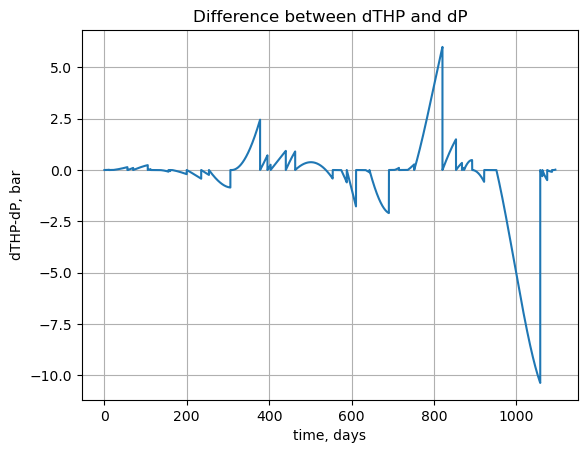

In [758]:
# Difference between dTHP and dP

delta = data2.dTHP.values - data2.dP.values
plt.plot(df.time, delta)
plt.title('Difference between dTHP and dP'); plt.ylabel('dTHP-dP, bar'); plt.xlabel('time, days')
plt.grid();

In [521]:
# Train test data split
#X_train, X_test, y_train, y_test = train_test_split(data.iloc[:,[0,1,2,3,4,5]], data.iloc[:,6],
#                                                    test_size=0.20, random_state=73073)

# 800 days - training, rest is testing (index = 14032)
X_train1 = data1.loc[data1.time<800, ['time', 'q', 'FPR', 'THP', 'B']]
X_test1 = data1.loc[data1.time>800, ['time', 'q', 'FPR', 'THP', 'B']].reset_index(drop=True)
y_train1 = data1.loc[data1.time<800, ['BHP']]
y_test1 = data1.loc[data1.time>800, ['BHP']].reset_index(drop=True) # reset indexes for test samples


X_train2 = data2.loc[df.time<800, ['FPR', 'B', 'dt', 'dTHP', 'shutin', 'dq']]
X_test2 = data2.loc[df.time>800, ['FPR', 'B', 'dt', 'dTHP', 'shutin', 'dq']].reset_index(drop=True)
y_train2 = data2.loc[df.time<800, ['dP']]
y_test2 = data2.loc[df.time>800, ['dP']].reset_index(drop=True)

X_train3 = data3.loc[df.time<800, ['FPR', 'B', 'dt', 'dTHP_noise', 'shutin', 'dq']]
X_test3 = data3.loc[df.time>800, ['FPR', 'B', 'dt', 'dTHP_noise', 'shutin', 'dq']].reset_index(drop=True)
y_train3 = data3.loc[df.time<800, ['dP']]
y_test3 = data3.loc[df.time>800, ['dP']].reset_index(drop=True)

X_train4 = data4.loc[df.time<800, ['FPR', 'B', 'dt', 'shutin', 'dq']]
X_test4 = data4.loc[df.time>800, ['FPR', 'B', 'dt', 'shutin', 'dq']].reset_index(drop=True)
y_train4 = data4.loc[df.time<800, ['dP']]
y_test4 = data4.loc[df.time>800, ['dP']].reset_index(drop=True)

X_train5 = data5.loc[df.time<800, ['q', 'FPR', 'B', 'dt', 'shutin', 'prev_q']]
X_test5 = data5.loc[df.time>800, ['q', 'FPR', 'B', 'dt', 'shutin', 'prev_q']].reset_index(drop=True)
y_train5 = data5.loc[df.time<800, ['dP']]
y_test5 = data5.loc[df.time>800, ['dP']].reset_index(drop=True)

In [1035]:
# Scaling

scaler = MinMaxScaler()
scaler_y = MinMaxScaler()

# Fit
scaler.fit(data2.iloc[:,[0,1,2,3,4,5]])
scaler_y.fit(data2.iloc[:,6].values.reshape(-1,1))

# Scale
X_train_s = scaler.transform(X_train2); X_test_s = scaler.transform(X_test2)
y_train_s = scaler_y.transform(y_train2); y_test_s = scaler_y.transform(y_test2)

### Feature ranking. Mutual information. Correlation

Feature ranking:
1. feature THP = 1.000000
2. feature time = 0.878853
3. feature FPR = 0.829883
4. feature B = 0.674442
5. feature q = 0.328478


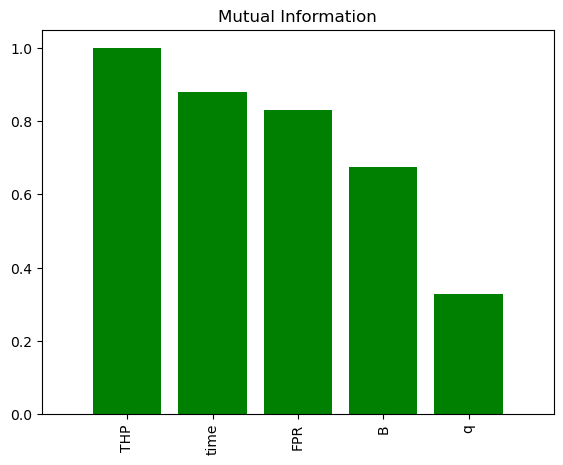

In [759]:
# CHOOSE WHICH DATA TO USE - 1,2,3

x = data1.iloc[:,[0,1,2,3,4]]              # separate DataFrames for predictor and response features
y = data1.iloc[:,[5]]

mi = mutual_info_regression(x,np.ravel(y)) # calculate mutual information
mi /= np.max(mi)                          # calculate relative mutual information

indices = np.argsort(mi)[::-1]            # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %s = %f" % (f + 1, x.columns[indices][f], mi[indices[f]]))

plt.subplot(111)                          # plot the relative mutual information 
plt.title("Mutual Information")
plt.bar(range(x.shape[1]), mi[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

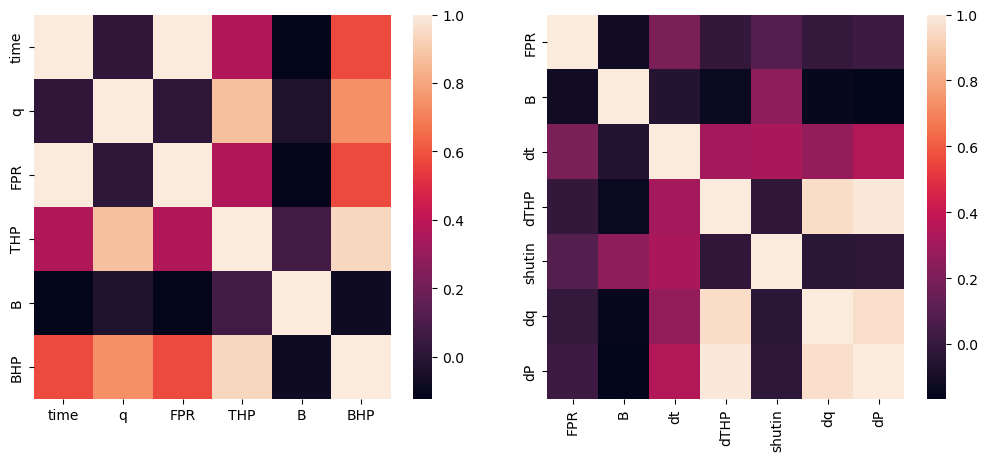

In [753]:
plt.subplot(1,2,1)
sns.heatmap(data1.corr())

plt.subplot(1,2,2)
sns.heatmap(data2.corr())

plt.subplots_adjust(left=0.0, bottom=0.0, right=1.5, top=0.8, wspace=0.15, hspace=0.1)
plt.show()

### Random forest

In [1011]:
# Random forest model  
#CHOOSE DATASET TO TRAIN - 1,2,3
rf, prediction_R, MSE_R, Var_Exp_R, R2_R, corr_R, error_R, mean_R, std_R = random_forest(X_train2, X_test2, 
                                                                            y_train2, y_test2)

Error standard deviation is 2.57 bar
Mean squared error is 8.30
Coefficiant of determination is 0.955
Correlation coefficient is 0.977
Variance explained score is 0.965


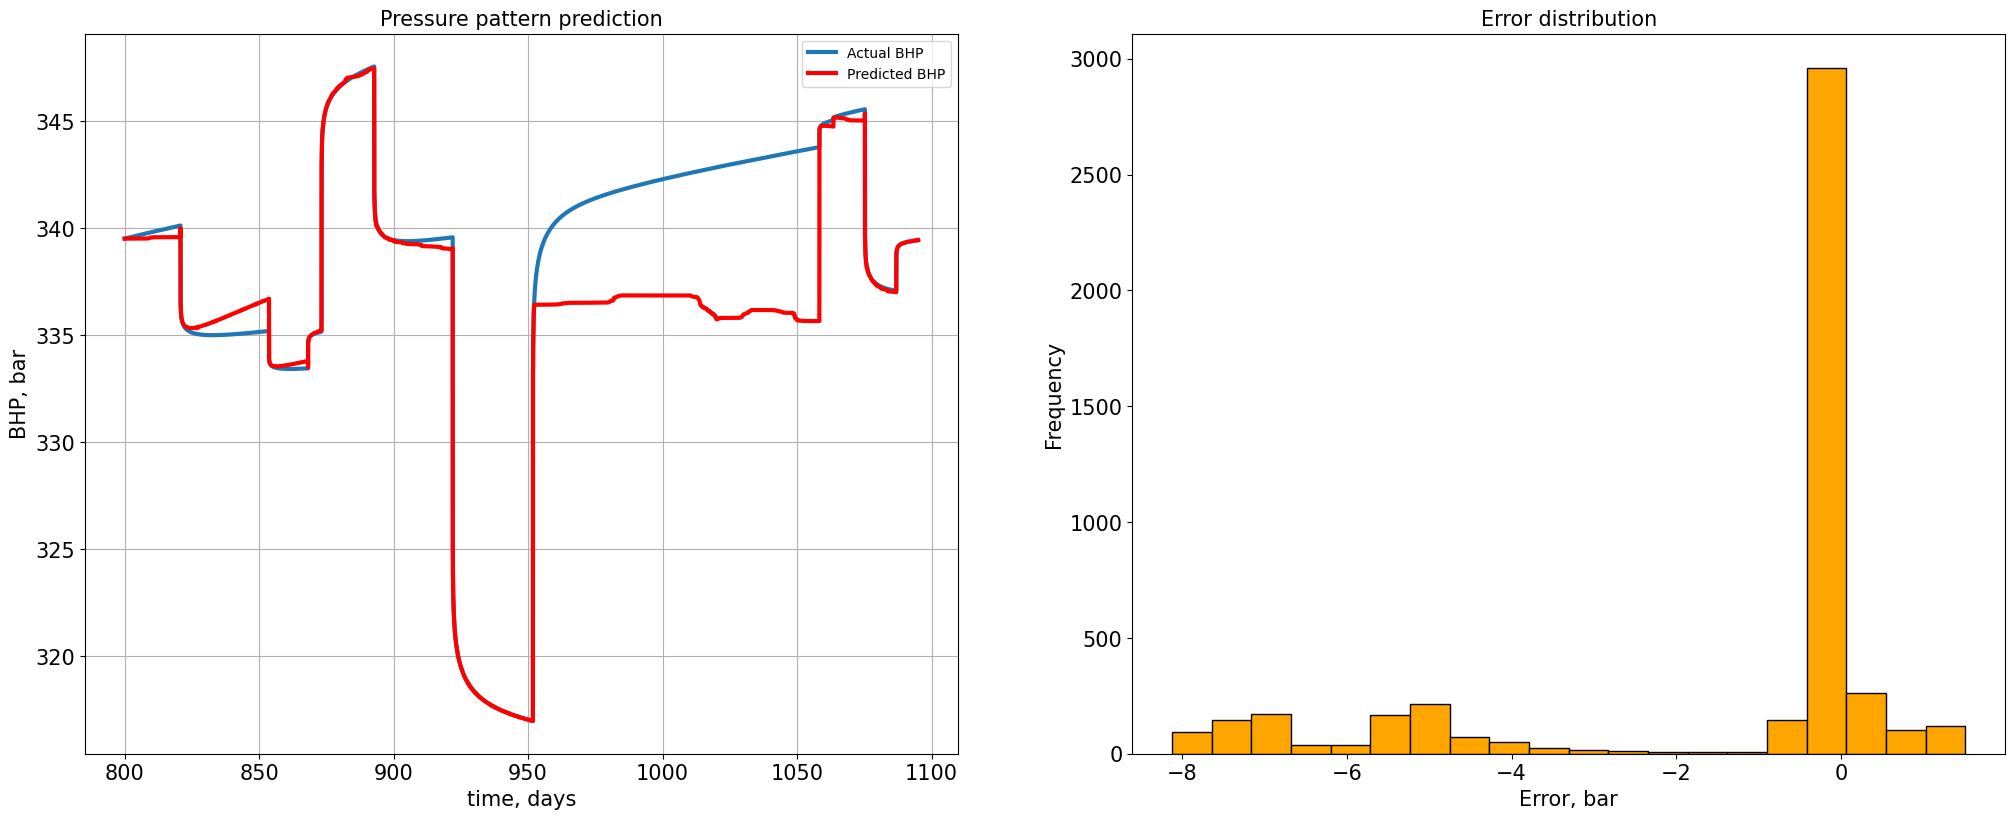

In [1012]:
# CHOOSE Y_TEST TO USE - 1,2 or 3

plot_results(y_test2, df, prediction_R, MSE_R, Var_Exp_R, R2_R, corr_R, error_R, mean_R, std_R)

Feature ranking:
1. feature 0 (0.881781)
2. feature 3 (0.067724)
3. feature 4 (0.049467)
4. feature 2 (0.000643)
5. feature 1 (0.000384)


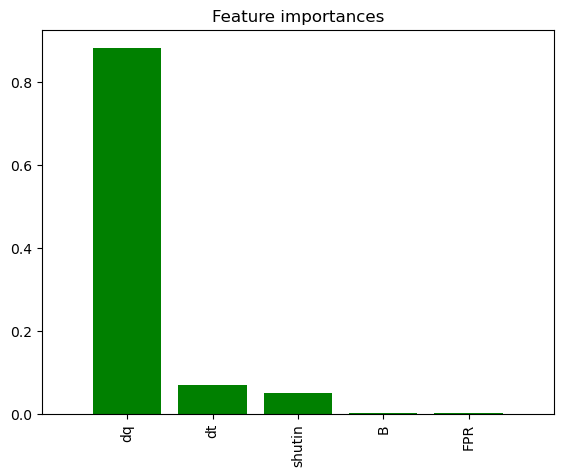

In [359]:
# CHOOSE X_TRAIN TO USE - 1,2 or 3
x = X_train4

importances = rf.feature_importances_     # extract the expected feature importances
std1 = np.std([tree.feature_importances_ for tree in rf.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importances)[::-1]   # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

### K-Nearest Neighbors model

In [997]:
# Hyperparameters tuning.  CHOOSE Y_TEST TO USE - 1,2,3
Y = y_test4

k = 1
dist_error = []
unif_error = []
k_mat = []
while k <= 250:
    neigh_dist = KNeighborsRegressor(weights = 'distance', n_neighbors=k, p = 2)
    neigh_dist_fit = neigh_dist.fit(X_train_s,y_train_s)  
    y_pred_s = neigh_dist_fit.predict(X_test_s)
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1))
    MSE = metrics.mean_squared_error(Y,y_pred)
    dist_error.append(MSE)
    
    neigh_unif = KNeighborsRegressor(weights = 'uniform', n_neighbors=k, p = 2)
    neigh_unif_fit = neigh_unif.fit(X_train_s,y_train_s)  
    y_pred_s = neigh_unif_fit.predict(X_test_s)
    y_pred = scaler_y.inverse_transform(y_pred_s.reshape(-1,1))
    MSE = metrics.mean_squared_error(Y,y_pred)
    unif_error.append(MSE)
    k_mat.append(k)
    k = k + 1

Minimum error using arithmetic average is 44.21 when k = 195
Minimum error using inverse distance weighting is 44.21 when k = 195


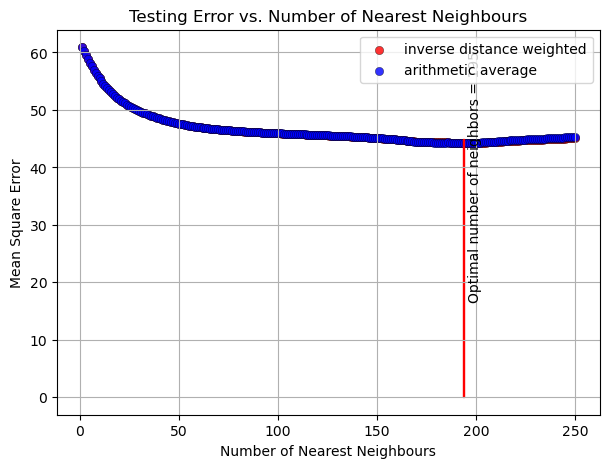

In [998]:
print('Minimum error using arithmetic average is ' + str("{:0.2f}".format(min(unif_error))) + ' when k = ' + 
     str(unif_error.index(min(unif_error))+1))
print('Minimum error using inverse distance weighting is ' + str("{:0.2f}".format(min(dist_error))) + ' when k = ' + 
     str(dist_error.index(min(dist_error))+1))


# Plot the hyperparameter tuning process
plt.figure(figsize=(7,5))
plt.scatter(k_mat,dist_error,s=None, c='red',label = 'inverse distance weighted',
            marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.scatter(k_mat,unif_error,s=None, c='blue',label = 'arithmetic average',
            marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.arrow(np.argmin(unif_error),0,0,45,width=0.5,color='red',head_length=0.0,head_width=0.0)
plt.annotate('Optimal number of neighbors = ' + str("{:0.0f}".format(np.argmin(unif_error)+1)),
             (np.argmin(unif_error)+2,17),rotation=90)
plt.title('Testing Error vs. Number of Nearest Neighbours');
plt.xlabel('Number of Nearest Neighbours'); plt.ylabel('Mean Square Error')
#plt.ylim(34,39)
plt.legend(); plt.grid()
plt.show()

In [1004]:
# K-Nearest model  CHOOSE Y_TEST TO USE - 1,2,3
kn, prediction_K, MSE_K, Var_Exp_K, R2_K, corr_K, error_K, mean_K, std_K = k_nearest(X_train_s, X_test_s, 
                                                            y_train_s, y_test2, weights='uniform',
                                                            n_neighbors =1, p=1)

Error standard deviation is 3.45 bar
Mean squared error is 13.58
Coefficiant of determination is 0.927
Correlation coefficient is 0.963
Variance explained score is 0.936


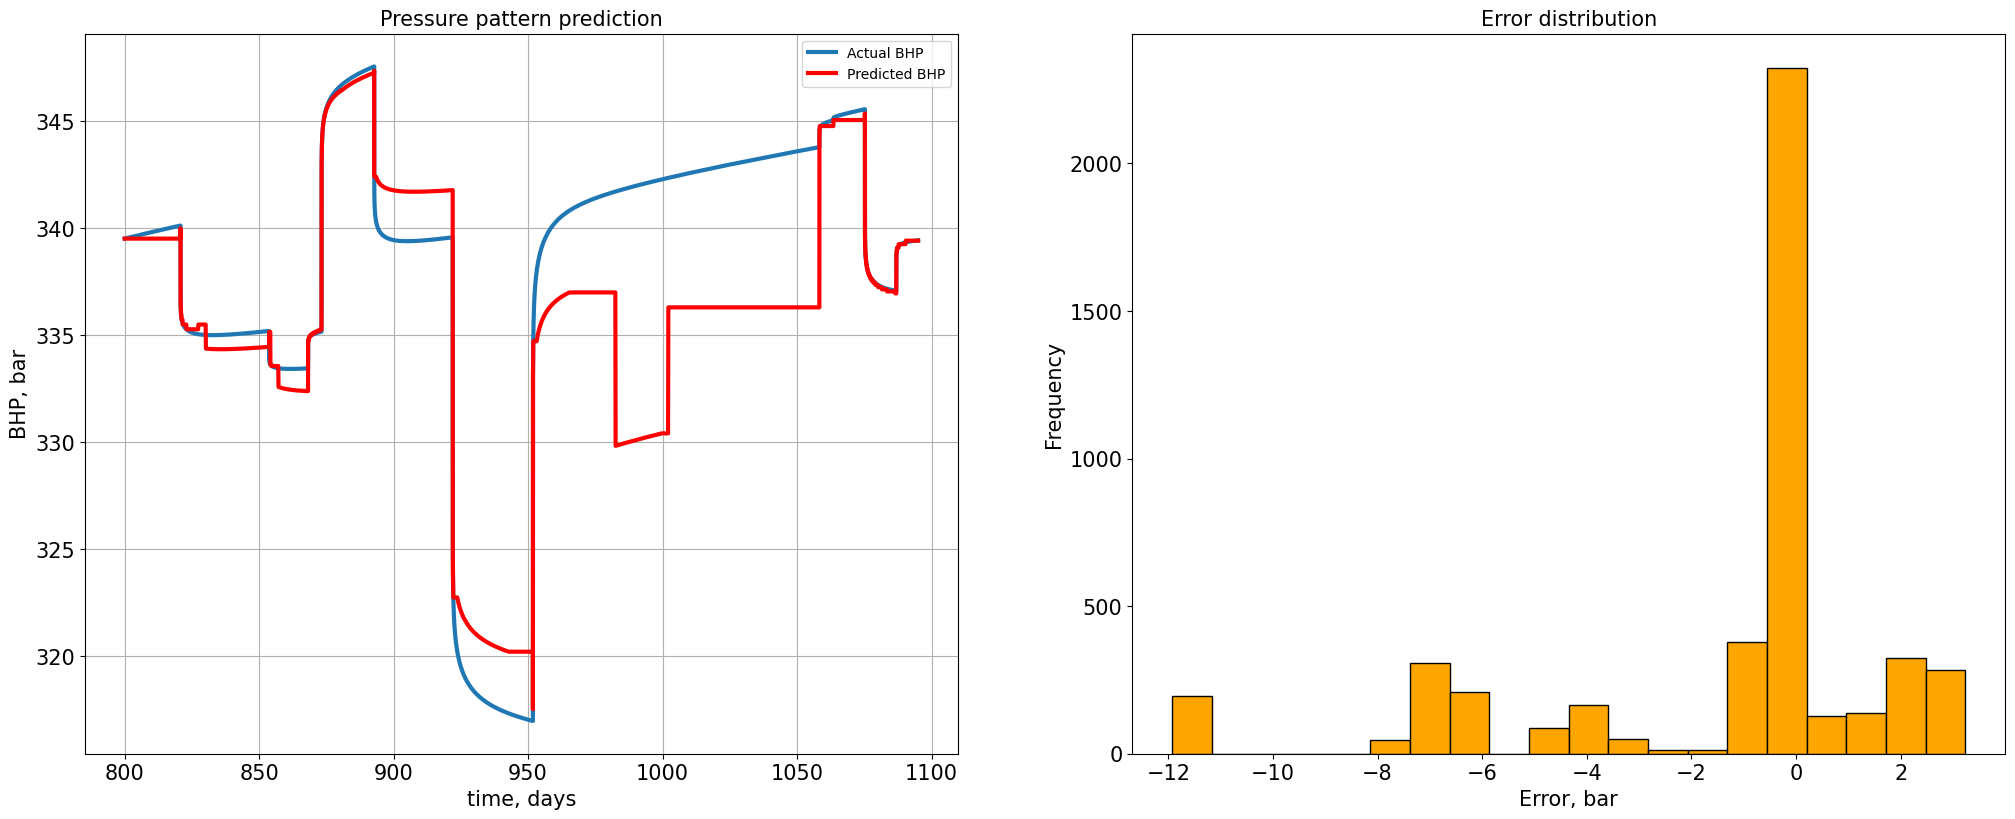

In [1005]:
# CHOOSE Y_TEST TO USE - 1,2 or 3

plot_results(y_test2, df, prediction_K, MSE_K, Var_Exp_K, R2_K, corr_K, error_K, mean_K, std_K)

### Gradient Boosting Desicion Trees Model

Complete of 100:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  

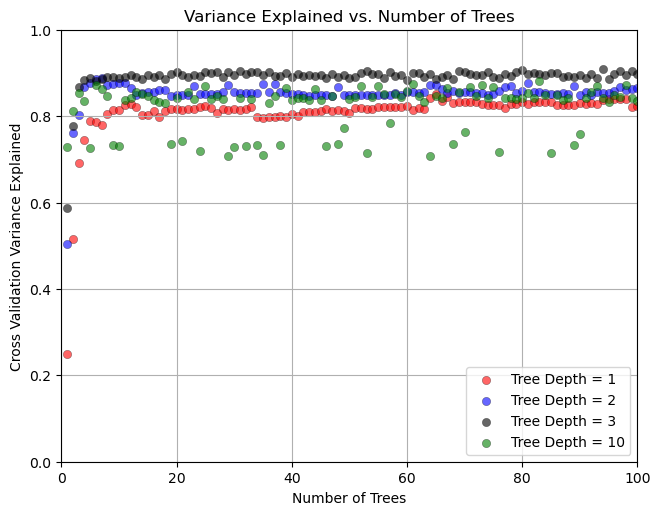

In [424]:
# Max depth - Number of trees tuning. Learning rate = 0.1
# CHOOSE DATA TO USE - 1,2,3:
predictors = X_train5; predictors_test = X_test5
response = y_train5; response_test = y_test5

num_trees = np.linspace(1,100,100)
max_features = 1
boosting_models1 = []; boosting_models2 = []; boosting_models3 = []; boosting_models4 = []
score1 = []; score2 = []; score3 = []; score4 = [] 

params1 = {
    'loss': 'ls',                                      # L2 Norm - least squares
    'max_depth': 1,                                    # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                 # tree construction criteria is mean square error over training
}

params2 = {
    'loss': 'ls',                                      # L2 Norm - least squares
    'max_depth': 2,                                    # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                 # tree construction criteria is mean square error over training
}

params3 = {
    'loss': 'ls',                                      # L2 Norm - least squares
    'max_depth': 3,                                    # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                 # tree construction criteria is mean square error over training
}

params4 = {
    'loss': 'ls',                                      # L2 Norm - least squares
    'max_depth': 10,                                   # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                 # tree construction criteria is mean square error over training
}

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees in our random forest
    boosting_models1.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params1))
    boosting_models1[index-1].fit(X = predictors, y = response)
    score1.append(boosting_models1[index-1].score(X = predictors_test, y = response_test))
    
    boosting_models2.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params2))
    boosting_models2[index-1].fit(X = predictors, y = response)
    score2.append(boosting_models2[index-1].score(X = predictors_test, y = response_test)) 
    
    boosting_models3.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params3))
    boosting_models3[index-1].fit(X = predictors, y = response)
    score3.append(boosting_models3[index-1].score(X = predictors_test, y = response_test)) 
    
    boosting_models4.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params4))
    boosting_models4[index-1].fit(X = predictors, y = response)
    score4.append(boosting_models4[index-1].score(X = predictors_test, y = response_test)) 

    print(str(index)+ ', ', end =" ")
    index = index + 1
    
plt.subplot(111)                                            # plot jackknife results for all cases
plt.scatter(num_trees,score1,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6,
            linewidths=0.3, edgecolors="black", label = "Tree Depth = 1")
plt.scatter(num_trees,score2,s=None, c='blue', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6,
            linewidths=0.3, edgecolors="black", label = "Tree Depth = 2")
plt.scatter(num_trees,score3,s=None, c='black', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6,
            linewidths=0.3, edgecolors="black", label = "Tree Depth = 3")
plt.scatter(num_trees,score4,s=None, c='green', marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.6,
            linewidths=0.3, edgecolors="black", label = "Tree Depth = 10")

plt.title('Variance Explained vs. Number of Trees'); 
plt.xlabel('Number of Trees'); plt.ylabel('Cross Validation Variance Explained')
plt.xlim(0,100); plt.ylim(0,1.0); plt.legend(loc='lower right'); plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
plt.show()

Complete of 100:  1,  2,  3,  4,  5,  6,  7,  8,  9,  10,  11,  12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,  91,  92,  93,  94,  95,  96,  97,  98,  99,  100,  

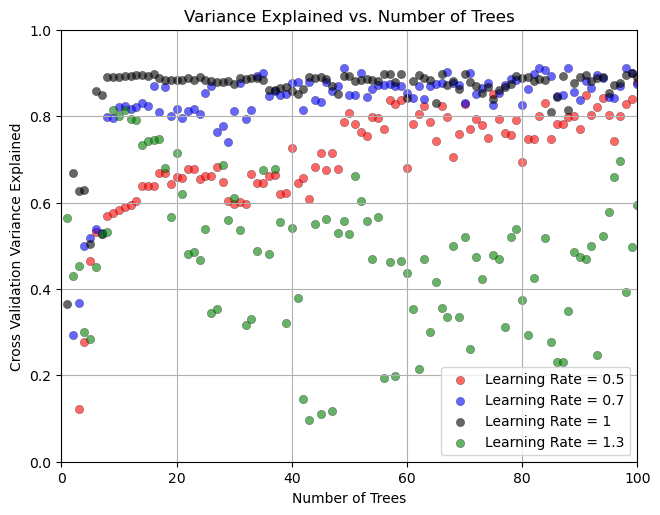

In [1032]:
# Learning rate - Number of trees tuning. Max depth = 2
# CHOOSE DATA TO USE - 1,2,3:
predictors = X_train1; predictors_test = X_test1
response = y_train1; response_test = y_test1

num_trees = np.linspace(1,100,100)
max_features = 1
boosting_models1 = []; boosting_models2 = []; boosting_models3 = []; boosting_models4 = []
score1 = []; score2 = []; score3 = []; score4 = [] 

params1 = {
    'loss': 'ls',                                     # L2 Norm - least squares
    'max_depth': 2,                                   # maximum depth per tree
    'learning_rate': 0.5,
    'criterion': 'mse'                                # tree construction criteria is mean square error over training
}

params2 = {
    'loss': 'ls',                                     # L2 Norm - least squares
    'max_depth': 2,                                   # maximum depth per tree
    'learning_rate': 0.7,
    'criterion': 'mse'                                # tree construction criteria is mean square error over training
}

params3 = {
    'loss': 'ls',                                     # L2 Norm - least squares
    'max_depth': 2,                                   # maximum depth per tree
    'learning_rate': 1,
    'criterion': 'mse'                                # tree construction criteria is mean square error over training
}

params4 = {
    'loss': 'ls',                                     # L2 Norm - least squares
    'max_depth': 2,                                   # maximum depth per tree
    'learning_rate': 1.3,
    'criterion': 'mse'                                # tree construction criteria is mean square error over training
}

index = 1
print('Complete of ' + str(len(num_trees)) + ': ', end =" ")
for num_tree in num_trees:                                  # loop over number of trees in our random forest
    boosting_models1.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params1))
    boosting_models1[index-1].fit(X = predictors, y = response)
    score1.append(boosting_models1[index-1].score(X = predictors_test, y = response_test))
    
    boosting_models2.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params2))
    boosting_models2[index-1].fit(X = predictors, y = response)
    score2.append(boosting_models2[index-1].score(X = predictors_test, y = response_test)) 
    
    boosting_models3.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params3))
    boosting_models3[index-1].fit(X = predictors, y = response)
    score3.append(boosting_models3[index-1].score(X = predictors_test, y = response_test)) 
    
    boosting_models4.append(GradientBoostingRegressor(n_estimators=int(num_tree),**params4))
    boosting_models4[index-1].fit(X = predictors, y = response)
    score4.append(boosting_models4[index-1].score(X = predictors_test, y = response_test)) 

    print(str(index)+ ', ', end =" ")
    index = index + 1
    
plt.subplot(111)                                            # plot jackknife results for all cases                                        
plt.scatter(num_trees,score1,s=None, c='red', marker=None, cmap=None, norm=None, vmin=None, vmax=None,
            alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 0.5")
plt.scatter(num_trees,score2,s=None, c='blue', marker=None, cmap=None, norm=None, vmin=None, vmax=None,
            alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 0.7")
plt.scatter(num_trees,score3,s=None, c='black', marker=None, cmap=None, norm=None, vmin=None, vmax=None,
            alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 1")
plt.scatter(num_trees,score4,s=None, c='green', marker=None, cmap=None, norm=None, vmin=None, vmax=None,
            alpha=0.6, linewidths=0.3, edgecolors="black", label = "Learning Rate = 1.3")

plt.title('Variance Explained vs. Number of Trees'); 
plt.xlabel('Number of Trees'); plt.ylabel('Cross Validation Variance Explained')
plt.xlim(0,100); plt.ylim(0,1.0); plt.legend(loc='lower right'); plt.grid()

plt.subplots_adjust(left=0.0, bottom=0.0, right=0.9, top=0.9, wspace=0.2, hspace=0.2)
plt.show()

In [1028]:
# Final Gradient Boosting model  CHOOSE DATASET TO USE - 1,2,3
bm, prediction_B, MSE_B, Var_Exp_B, R2_B, corr_B, error_B, mean_B, std_B = boosting(X_train1, X_test1, 
                                                            y_train1, y_test1, max_depth=2,
                                                            learning_rate=1, num_tree=10)

Error standard deviation is 2.32 bar
Mean squared error is 5.45
Coefficiant of determination is 0.891
Correlation coefficient is 0.944
Variance explained score is 0.892


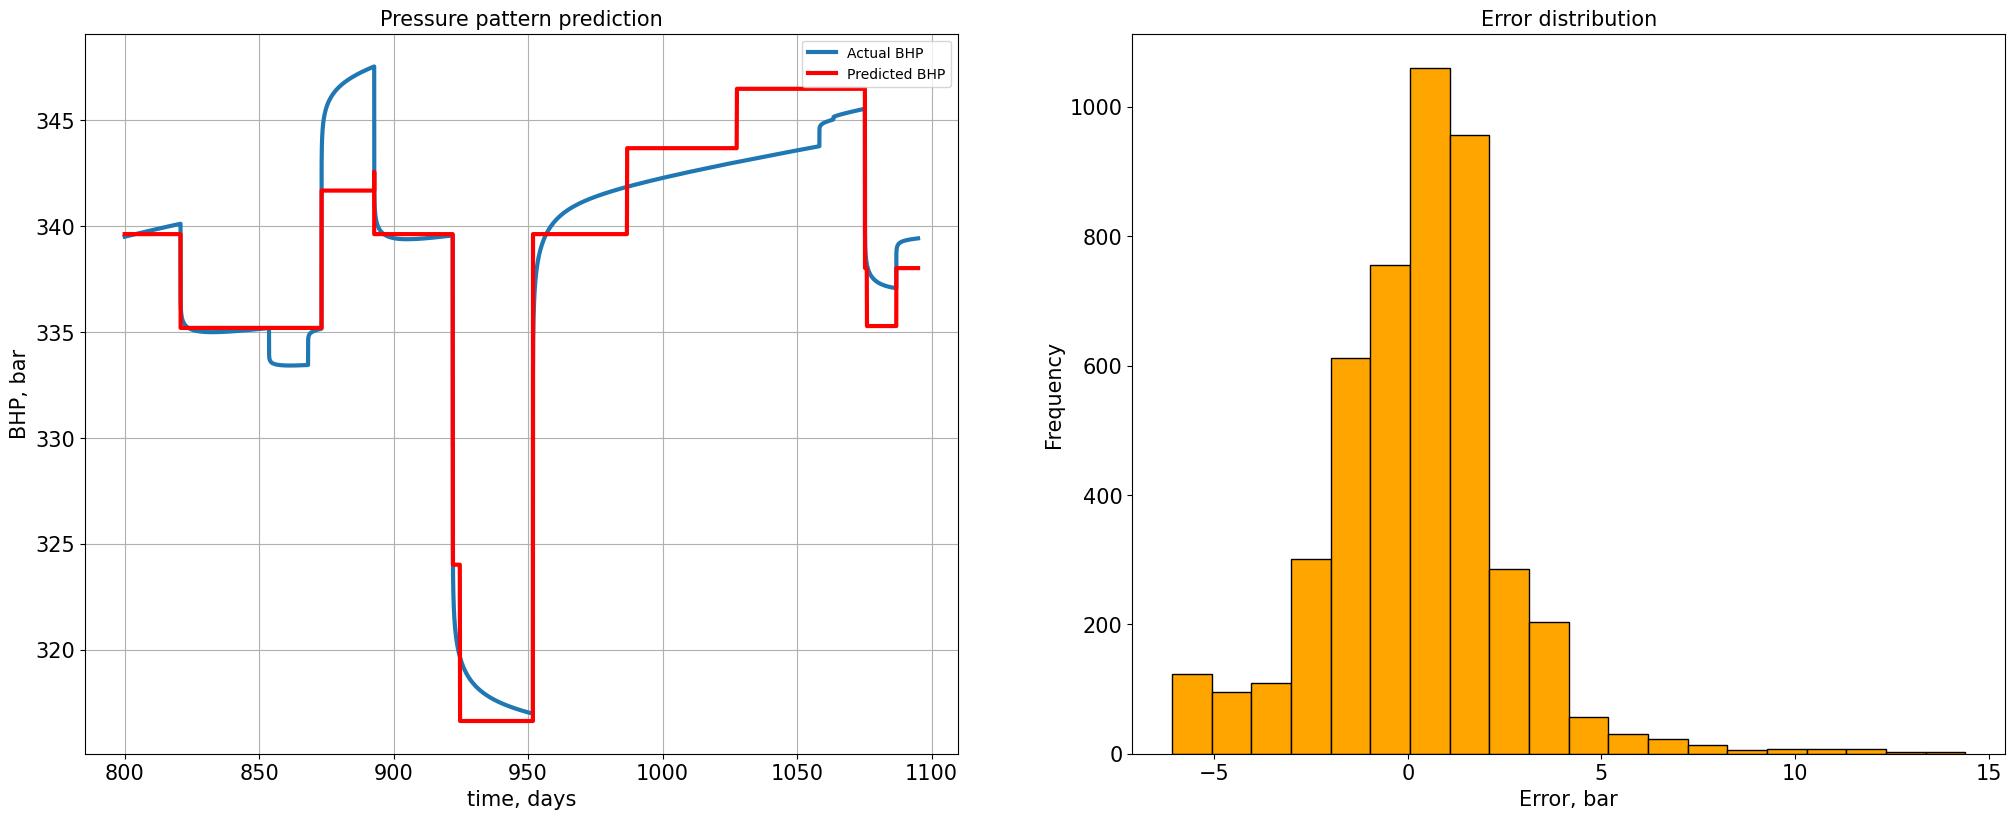

In [1029]:
# CHOOSE Y_TEST TO USE - 1,2 or 3

plot_results(y_test1, df, prediction_B, MSE_B, Var_Exp_B, R2_B, corr_B, error_B, mean_B, std_B)

Feature ranking:
1. feature 3 (0.942758)
2. feature 2 (0.042118)
3. feature 4 (0.008464)
4. feature 1 (0.005070)
5. feature 0 (0.001591)


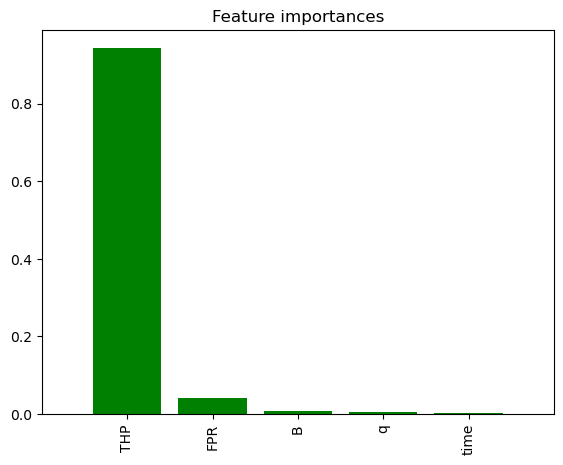

In [1030]:
# CHOOSE X_TRAIN TO USE - 1,2 or 3
x = X_train1

importances = bm.feature_importances_     # extract the expected feature importances
#std1 = np.std([tree.feature_importances_ for tree in bm.estimators_],axis=0) # calculate stdev over trees
indices = np.argsort(importances)[::-1]   # find indicies for descending order

print("Feature ranking:")                 # write out the feature importances
for f in range(x.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

plt.subplot(111)                          # plot the feature importance 
plt.title("Feature importances")
plt.bar(range(x.shape[1]), importances[indices],
       color="g", align="center")
plt.xticks(range(x.shape[1]), x.columns[indices],rotation=90)
plt.xlim([-1, x.shape[1]])
plt.subplots_adjust(left=0.0, bottom=0.0, right=0.8, top=0.8, wspace=0.2, hspace=0.2)
plt.show()

### Feedforward Neural Network for regression problem

In [1077]:
def build_model():
    model = Sequential([
        Dense(64, activation='relu', input_shape=(X_train_s.shape[1],)),
        Dense(64, activation='relu'),
        Dense(1)
    ])
    
    optimizer = tf.keras.optimizers.RMSprop(0.001)
    
    model.compile(loss='mse',
                 optimizer=optimizer,
                 metrics=['mae', 'mse'])
    return model

In [1078]:
keras.backend.clear_session()
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 64)                448       
                                                                 
 dense_1 (Dense)             (None, 64)                4160      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4,673
Trainable params: 4,673
Non-trainable params: 0
_________________________________________________________________


In [1083]:
# Model training
epochs = 100
batch_size = 50
history = model.fit(X_train_s, y_train_s, epochs=epochs, batch_size=batch_size,
                   validation_split=0.1).history

Epoch 1/100
253/253 [==============================] - 0s 898us/step - loss: 4.7449e-05 - mae: 0.0057 - mse: 4.7449e-05 - val_loss: 6.6864e-04 - val_mae: 0.0151 - val_mse: 6.6864e-04
Epoch 2/100
253/253 [==============================] - 0s 757us/step - loss: 4.7943e-05 - mae: 0.0056 - mse: 4.7943e-05 - val_loss: 5.9741e-04 - val_mae: 0.0161 - val_mse: 5.9741e-04
Epoch 3/100
253/253 [==============================] - 0s 811us/step - loss: 4.7134e-05 - mae: 0.0060 - mse: 4.7134e-05 - val_loss: 0.0011 - val_mae: 0.0233 - val_mse: 0.0011
Epoch 4/100
253/253 [==============================] - 0s 757us/step - loss: 4.6753e-05 - mae: 0.0057 - mse: 4.6753e-05 - val_loss: 0.0015 - val_mae: 0.0288 - val_mse: 0.0015
Epoch 5/100
253/253 [==============================] - 0s 753us/step - loss: 4.7390e-05 - mae: 0.0060 - mse: 4.7390e-05 - val_loss: 7.0797e-04 - val_mae: 0.0157 - val_mse: 7.0797e-04
Epoch 6/100
253/253 [==============================] - 0s 748us/step - loss: 4.6089e-05 - mae: 0.0058

253/253 [==============================] - 0s 718us/step - loss: 3.1944e-05 - mae: 0.0049 - mse: 3.1944e-05 - val_loss: 0.0011 - val_mae: 0.0230 - val_mse: 0.0011
Epoch 92/100
253/253 [==============================] - 0s 705us/step - loss: 3.1750e-05 - mae: 0.0047 - mse: 3.1750e-05 - val_loss: 7.9631e-04 - val_mae: 0.0195 - val_mse: 7.9631e-04
Epoch 93/100
253/253 [==============================] - 0s 700us/step - loss: 3.2368e-05 - mae: 0.0048 - mse: 3.2368e-05 - val_loss: 0.0011 - val_mae: 0.0221 - val_mse: 0.0011
Epoch 94/100
253/253 [==============================] - 0s 711us/step - loss: 3.0790e-05 - mae: 0.0045 - mse: 3.0790e-05 - val_loss: 0.0011 - val_mae: 0.0234 - val_mse: 0.0011
Epoch 95/100
253/253 [==============================] - 0s 711us/step - loss: 3.1004e-05 - mae: 0.0044 - mse: 3.1004e-05 - val_loss: 7.4652e-04 - val_mae: 0.0189 - val_mse: 7.4652e-04
Epoch 96/100
253/253 [==============================] - 0s 706us/step - loss: 3.1155e-05 - mae: 0.0048 - mse: 3.1155e

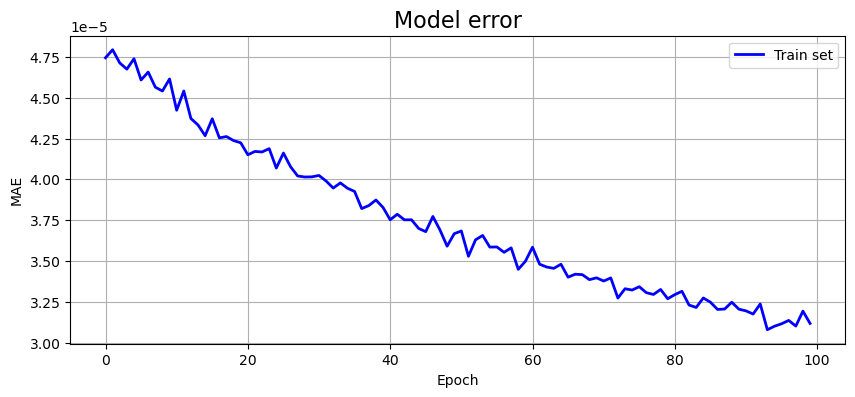

In [1084]:
#plot the training losses
fig, ax = plt.subplots(figsize=(10,4))
ax.plot(history['loss'], 'b', label='Train set', linewidth=2)
#ax.plot(history['val_loss'], 'r', label='Валидационная выборка', linewidth=2)
ax.set_title('Model error', fontsize=16)
ax.set_ylabel('MAE')
ax.set_xlabel('Epoch')
ax.legend(loc='best')
ax.grid()
plt.show()

In [1085]:
#NN results CHOOSE Y_TEST TO USE - 1,2,3
Y = y_test2

prediction_N_s = model.predict(X_test_s).reshape(-1,1)  #1d array convert to 2d
prediction_N = scaler_y.inverse_transform(prediction_N_s.reshape(-1,1))  #convert to 2d array
MSE_N = mean_squared_error(Y, prediction_N)
Var_Exp_N = explained_variance_score(Y, prediction_N)
R2_N = r2_score(Y, prediction_N)
corr_N = math.sqrt(R2_N)
error_N = prediction_N-Y.values
mean_N = np.mean(error_N)
std_N = np.std(error)

146/146 [==============================] - 0s 393us/step


Error standard deviation is 1.71 bar
Mean squared error is 3.46
Coefficiant of determination is 0.981
Correlation coefficient is 0.991
Variance explained score is 0.982


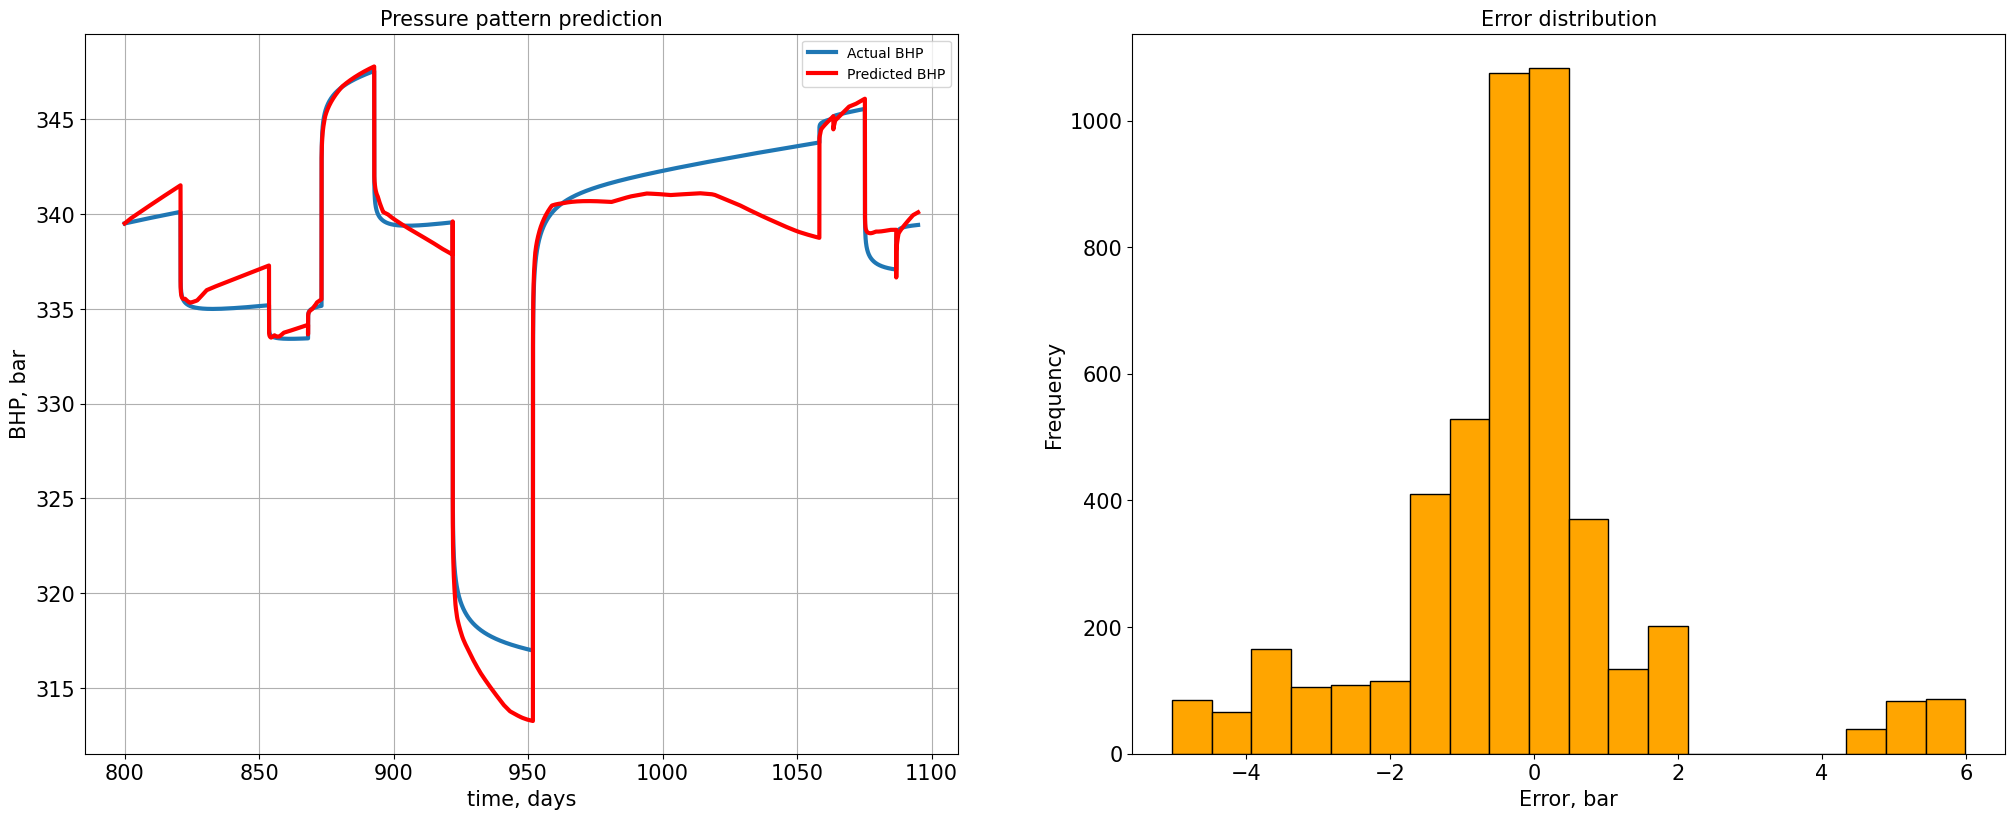

In [1086]:
# CHOOSE Y_TEST TO USE - 1,2 or 3

plot_results(y_test2, df, prediction_N, MSE_N, Var_Exp_N, R2_N, corr_N, error_N, mean_N, std_N)

In [1088]:
ANN_prediction

array([[17.47664  ],
       [17.488525 ],
       [17.500479 ],
       ...,
       [ 2.9500751],
       [ 2.9567897],
       [ 2.9634218]], dtype=float32)

### LASSO regression

In [933]:
# Hyperparameters tuning.  CHOOSE Y_TEST TO USE - 1,2,3
X_train = X_train4; X_test = X_test4; y_train = y_train4; y_test = y_test4

i = 1
lam_values = np.linspace(0.05,1,20)
lasso_error = []
lam = []
while i <= 100:
    lasso_reg, prediction_L, MSE_L, Var_Exp_L, R2_L, corr_L, error_L, mean_L, std_L  = lasso(X_train, X_test,
                                                                                         y_train, y_test, lam=i)
    lasso_error.append(MSE_L)
    lam.append(i)
    i += 1

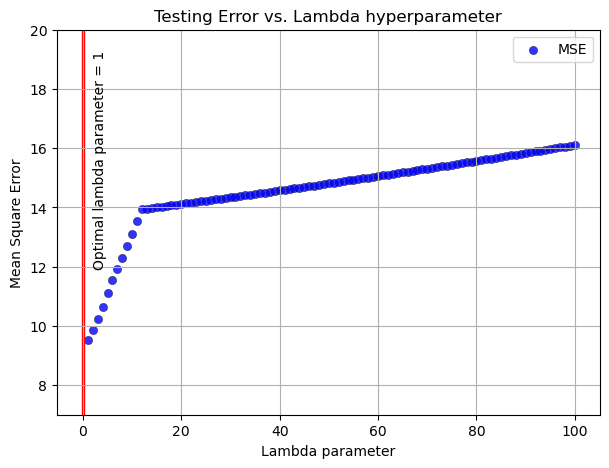

In [934]:
# Plot the hyperparameter tuning process
plt.figure(figsize=(7,5))
plt.scatter(lam,lasso_error,s=None, c='blue',label = 'MSE',
            marker=None, cmap=None, norm=None, vmin=None, vmax=None, alpha=0.8, linewidths=0.3, edgecolors="black")
plt.arrow(np.argmin(lasso_error),0,0,40,width=0.5,color='red',head_length=0.0,head_width=0.0)
plt.annotate('Optimal lambda parameter = ' + str("{:0.0f}".format(np.argmin(lasso_error)+1)),
             (np.argmin(lasso_error)+2,12),rotation=90)
plt.title('Testing Error vs. Lambda hyperparameter');
plt.xlabel('Lambda parameter'); plt.ylabel('Mean Square Error')
plt.ylim(7,20)
plt.legend(); plt.grid()
#plt.xlim(0,50); plt.ylim(0,800000)
plt.show()

In [946]:
# CHOOSE DATA TO USE - 1,2 or 3

lasso_reg, prediction_L, MSE_L, Var_Exp_L, R2_L, corr_L, error_L, mean_L, std_L = lasso(X_train1, X_test1,
                                                                                       y_train1, y_test1, lam=17)

Error standard deviation is 1.71 bar
Mean squared error is 8.14
Coefficiant of determination is 0.837
Correlation coefficient is 0.915
Variance explained score is 0.838


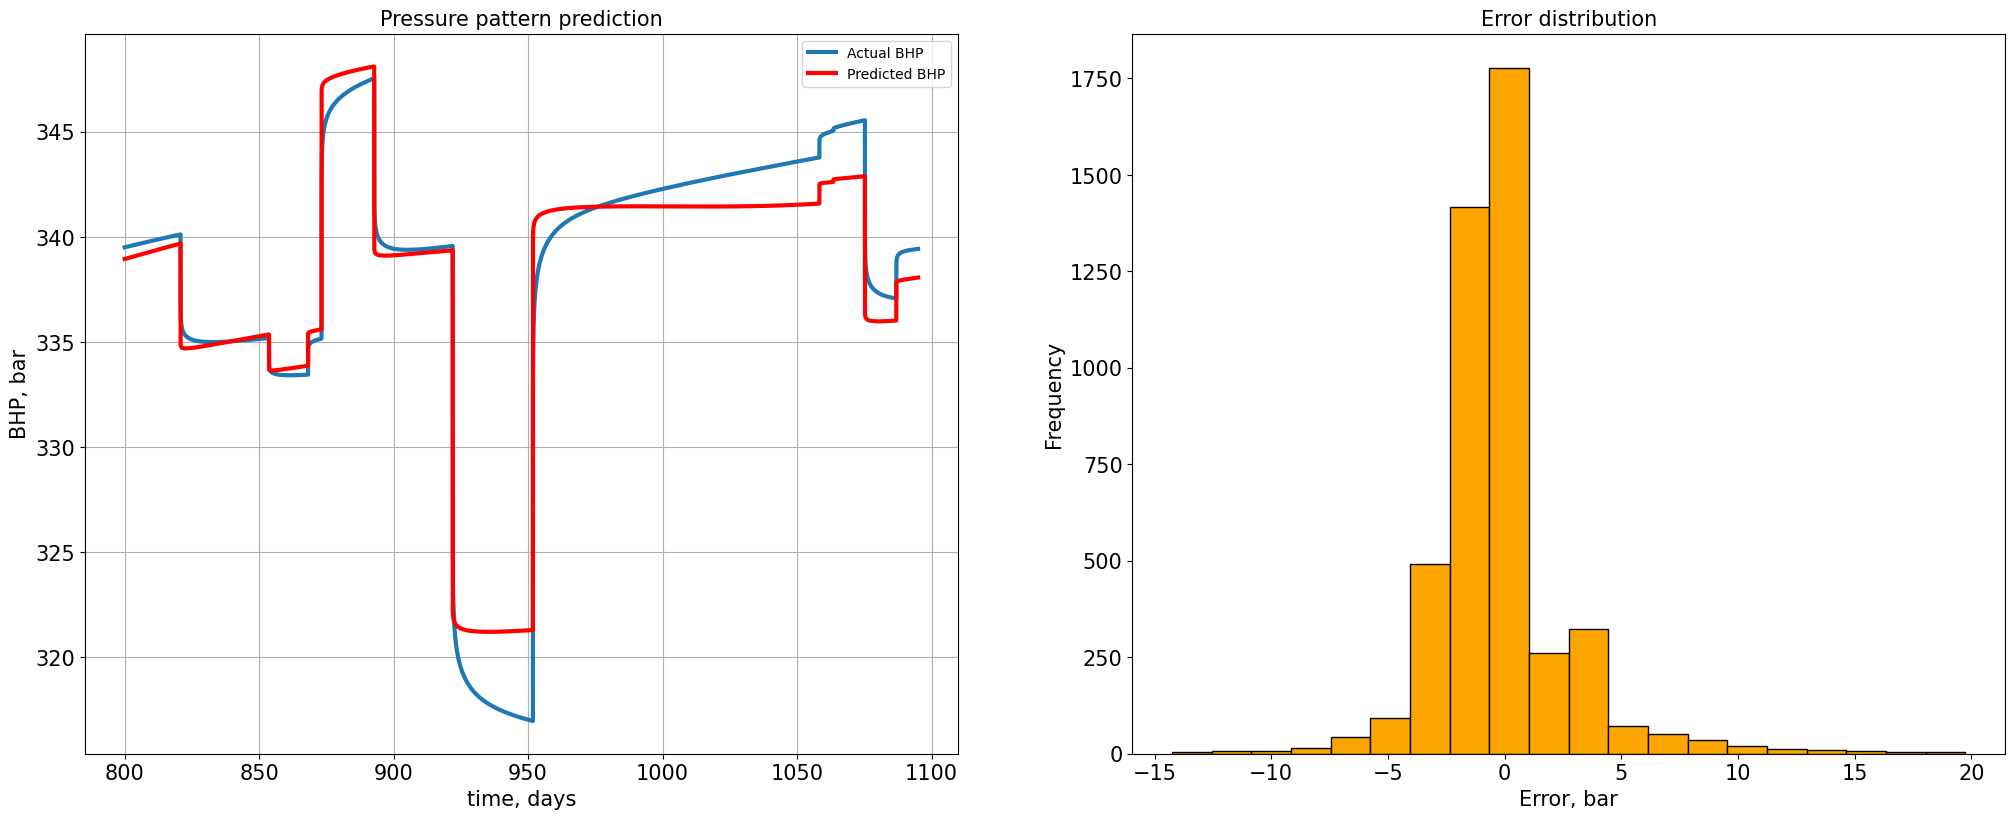

In [947]:
# CHOOSE Y_TEST TO USE - 1,2 or 3

plot_results(y_test1, df, prediction_L, MSE_L, Var_Exp_L, R2_L, corr_L, error_L, mean_L, std_L)

## Results comparison

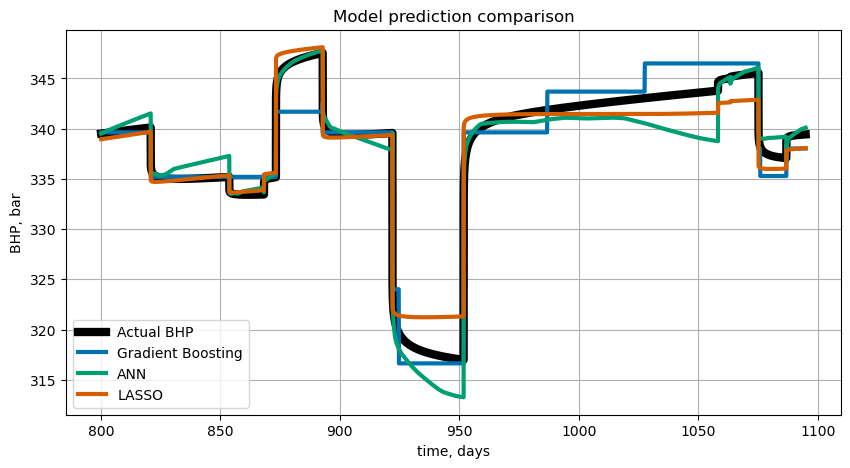

In [1101]:
plt.style.use('seaborn-v0_8-colorblind')
predictions = [prediction_R, prediction_B, prediction_N, prediction_K, prediction_L]
BHP_predicted = []
for prediction in predictions:
    if prediction[1,0] > 100:
        BHP_predicted.append(prediction)
    else:
        BHP_predicted.append(BHP_backtransform(prediction, df, Y))
BHP_actual = df.loc[df.time>800, ['BHP']].values       
T = df.loc[df.time>800, ['time']].values

plt.figure(figsize=(10,5))
plt.plot(T, BHP_actual, linewidth=6, label='Actual BHP', c='k')
#plt.plot(T, BHP_predicted[0], linewidth=3, label='Random Forest')
plt.plot(T, BHP_predicted[1], linewidth=3, label='Gradient Boosting')
plt.plot(T, BHP_predicted[2], linewidth=3, label='ANN')
#plt.plot(T, BHP_predicted[3], linewidth=3, label='K-nearest neighbors')
plt.plot(T, BHP_predicted[4], linewidth=3, label='LASSO')
plt.title('Model prediction comparison'); plt.xlabel('time, days'); plt.ylabel('BHP, bar')
plt.grid(); plt.legend()
plt.show()